# Intention Classification Model

## Goals/Problem/Context
The goal is to interpret sentences from July 2024 intentions survey and match a user to the appropriate journey.

## Data Used/ Filtering/ Methods
This project uses survey data from 'intentions_survey_data_july_2024.json', which includes intentions and the corresponding journey label. I use the SentenceTransformer model to encode the sentences into embeddings-- it performed better than the TFIDF model (and about the same as the OpenAI model) and is open source, unlike the OpenAI model.

In [28]:
import json
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [29]:
with open('intentions_survey_data_july_2024.json', 'r') as file:
    survey_data = json.load(file)

sentences = [entry['text'] for entry in survey_data]
journeys = [entry['label'] for entry in survey_data]

In [30]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

embeddings_df = pd.DataFrame(embeddings)
metadata_df = pd.DataFrame({'journey_label': journeys})

X = embeddings_df.values

## Model/ Metrics
1. Sentence Encoding: the sentences are converted into embeddings using the Sentence Transformers model.
2. Model Selection: used the KNN classifier with cosine distance as the metric to classify the sentences into journey categories.
3. Evaluation Metrics: evaluated the model using accuracy, ROC AUC score, and classification reports.

In [31]:
def train_and_evaluate_knn(X, y, n_neighbors):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    neigh.fit(X_train, y_train)
    
    predictions = neigh.predict(X_test)
    probabilities = neigh.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)
    report = classification_report(y_test, predictions, zero_division=1)
    
    return accuracy, roc_auc, report, y_test, probabilities

## Results & Conclusion
The model determines the optimal number of neighbors and corresponding ROC AUC scores, successfully matching user intentions to the appropriate Thrive journey. Compared to the other ROC AUC's, the model struggles slightly to correctly match users to the Stress Management journey. In general, the classifier allows for a more personalized Thrive experience.

Results for Connection:
Best n_neighbors: 3
Best ROC AUC: 0.9408602150537635
-


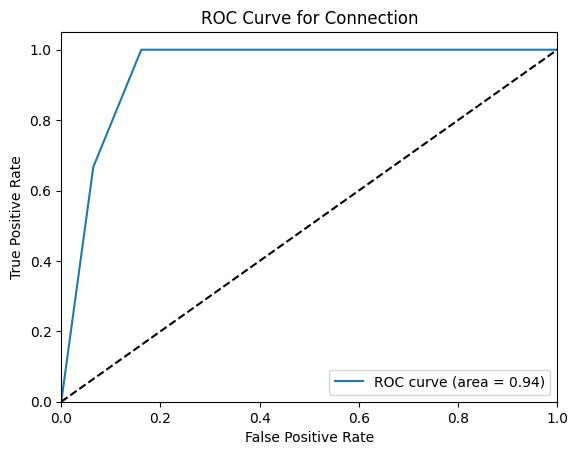

Results for Stress Management:
Best n_neighbors: 3
Best ROC AUC: 0.8857142857142857
-


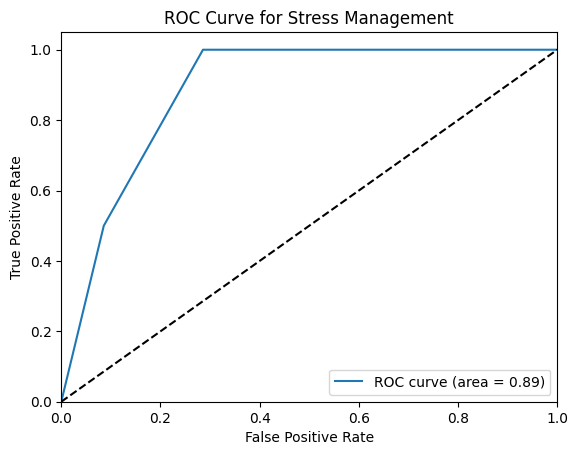

Results for Food:
Best n_neighbors: 6
Best ROC AUC: 0.989247311827957
-


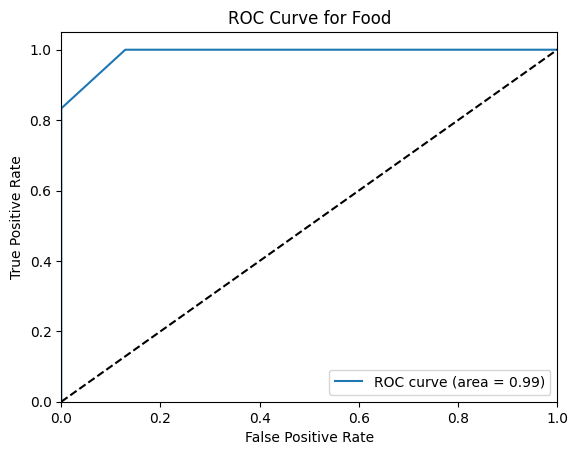

Results for Movement:
Best n_neighbors: 9
Best ROC AUC: 0.951048951048951
-


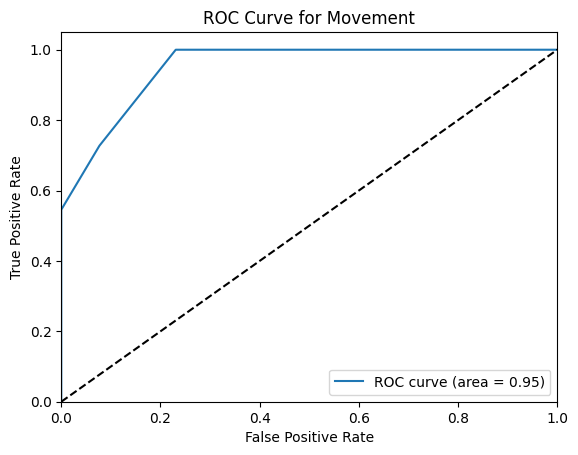

Results for Sleep:
Best n_neighbors: 3
Best ROC AUC: 0.990625
-


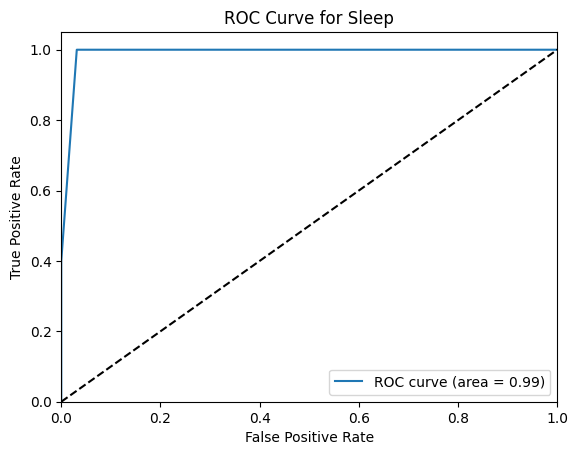

In [32]:
journey_labels = ['Connection', 'Stress Management', 'Food', 'Movement', 'Sleep']

results = {}
for journey in journey_labels:
    y = [1 if label == journey else 0 for label in metadata_df['journey_label']]
    
    best_auc = 0
    best_n_neighbors = 0
    for n in range(1, 11):
        accuracy, roc_auc, report, y_test, probabilities = train_and_evaluate_knn(X, y, n)
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_n_neighbors = n
            best_report = report
            best_y_test = y_test
            best_probabilities = probabilities
    
    results[journey] = {
        'best_n_neighbors': best_n_neighbors,
        'best_auc': best_auc,
        'classification_report': best_report
    }
    
    print(f"Results for {journey}:")
    print(f"Best n_neighbors: {best_n_neighbors}")
    print(f"Best ROC AUC: {best_auc}")
    print("-")

    fpr, tpr, _ = roc_curve(best_y_test, best_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {best_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {journey}')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
for journey, result in results.items():
    print(f"Final results for {journey}:")
    print(f"Best n_neighbors: {result['best_n_neighbors']}")
    print(f"Best ROC AUC: {result['best_auc']}")
    print("-")

Final results for Connection:
Best n_neighbors: 3
Best ROC AUC: 0.9408602150537635
-
Final results for Stress Management:
Best n_neighbors: 3
Best ROC AUC: 0.8857142857142857
-
Final results for Food:
Best n_neighbors: 6
Best ROC AUC: 0.989247311827957
-
Final results for Movement:
Best n_neighbors: 9
Best ROC AUC: 0.951048951048951
-
Final results for Sleep:
Best n_neighbors: 3
Best ROC AUC: 0.990625
-
